# Spectral Clustering and Ratio Cut Visualization
**Author:** BAIM Mohamed Jalal, 3113551810

In [1]:
# Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
import os
from PIL import Image

In [2]:
output_path = './Spectral_Clustering_viz'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [3]:
# Process to create GIF
def create_gif(name, output_dir, k, initialize, max_iter):
    """
    Create a GIF from the saved clustering images.
    Args:
        output_dir (str): Directory where images are saved.
        max_iter (int): Total number of iterations visualized.
    """
    images = []
    output_dir = os.path.join(output_dir, name)
    for i in range(max_iter):
        filename = os.path.join(output_dir, f'nb_cluster{k}_iteration_{i}_init_{initialize}.png')
        if not os.path.exists(filename):
            continue
        images.append(imageio.imread(filename))
    if images:
        gif_filename = os.path.join(output_dir, f'clustering_nb_cluster{k}_init_{initialize}.gif')
        imageio.mimsave(gif_filename, images, duration=0.5)
        print(f"GIF saved at {gif_filename}")

def save_iteration_visualization(name, img_shape, clusters, k, iteration, initialize, output_dir):
    """
    Save the cluster assignment visualization for the current iteration.
    Args:
        img_shape (tuple): Shape of the original image (height, width, channels).
        clusters (numpy.ndarray): Cluster assignments for each pixel.
        k (int): Number of clusters.
        iteration (int): Current iteration number.
        output_dir (str): Directory to save the images.
    """
    output_dir = os.path.join(output_dir, name)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    H, W, _ = img_shape
    cluster_image = clusters.reshape(H, W)
    plt.figure(figsize=(8, 6))
    plt.imshow(cluster_image, cmap='tab20', interpolation='nearest')
    plt.title(f'Iteration {iteration}')
    plt.axis('off')
    filename = os.path.join(output_dir, f'nb_cluster{k}_iteration_{iteration}_init_{initialize}.png')
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

In [4]:
def kernel(img, gamma_s, gamma_c):
    """
    Compute the Gram matrix using a combined spatial and color Gaussian kernel.
    Parameters:
    img (numpy.ndarray): The input image data of shape (H, W, C).
    gamma_s (float): The hyper-parameter for spatial similarity.
    gamma_c (float): The hyper-parameter for color similarity.
    Returns:
    numpy.ndarray: The Gram matrix computed using the combined kernel function.
    """
    H, W, C = img.shape
    n_pixels = H * W
    img_flat = img.reshape(-1, C).astype(np.float64)  # Shape: (n_pixels, C)

    # Coordinates
    x_coords = np.arange(W)
    y_coords = np.arange(H)
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)
    spatial_coords = np.stack((x_grid, y_grid), axis=-1).reshape(-1, 2)  # Shape: (n_pixels, 2)

    # Scale features
    spatial_features = gamma_s * spatial_coords  # Shape: (n_pixels, 2)
    color_features = gamma_c * img_flat  # Shape: (n_pixels, C)

    # Combine features
    features = np.concatenate((spatial_features, color_features), axis=1)  # Shape: (n_pixels, 2 + C)
    sq_dists = np.sum((features[:, np.newaxis, :] - features[np.newaxis, :, :]) ** 2, axis=-1)  # Shape: (n_pixels, n_pixels)
    gram = np.exp(-sq_dists)

    return gram

In [5]:
def initialize_clusters(data, k, method="random"):
    """
    Initialize cluster centroids using random initialization or k-means++.
    Parameters:
    - data (numpy.ndarray): The dataset (n_samples, n_features).
    - k (int): The number of clusters.
    - method (str): Initialization method ("random" or "kmeans++").
    Returns:
    - numpy.ndarray: Initialized centroids of shape (k, n_features).
    """
    n_samples, n_features = data.shape

    if method == "random":
        # Random initialization: randomly select k points from the dataset as centroids
        indices = np.random.choice(n_samples, k, replace=False)
        return data[indices]

    elif method == "kmeans++":
        # K-means++ initialization
        centroids = [data[np.random.randint(0, n_samples)]]
        for _ in range(1, k):
            distances = np.min([np.linalg.norm(data - centroid, axis=1) for centroid in centroids], axis=0)
            probs = distances / np.sum(distances)
            new_centroid = data[np.random.choice(n_samples, p=probs)]
            centroids.append(new_centroid)
        return np.array(centroids)

    else:
        raise ValueError("Invalid method! Use 'random' or 'kmeans++'.")

def kmeans(data, k, max_iter=100, tol=1e-4, init_method="random", save_callback=None):
    """
    Perform K-means clustering with optional saving of intermediate results.
    Parameters:
    - data (numpy.ndarray): The dataset (n_samples, n_features).
    - k (int): The number of clusters.
    - max_iter (int): Maximum number of iterations.
    - tol (float): Tolerance for convergence.
    - init_method (str): Initialization method ("random" or "kmeans++").
    - save_callback (function): Optional callback to save visualizations during iterations.
    Returns:
    - numpy.ndarray: Cluster assignments of shape (n_samples,).
    - numpy.ndarray: Final centroids of shape (k, n_features).
    """
    centroids = initialize_clusters(data, k, method=init_method)
    for iteration in range(max_iter):
        # Assign clusters based on closest centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        clusters = np.argmin(distances, axis=1)

        # Save visualization if callback is provided
        if save_callback:
            save_callback(clusters, iteration)

        # Update centroids
        new_centroids = np.array([data[clusters == c].mean(axis=0) if np.any(clusters == c) else centroids[c] for c in range(k)])

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids

    return clusters, centroids

In [6]:
def visualize_clusters(image, clusters, title="Clustered Image"):
    """
    Visualize the clustered image.
    Parameters:
    - image (numpy.ndarray): Original image (h, w, channels).
    - clusters (numpy.ndarray): Cluster assignments of shape (h*w,).
    - title (str): Title for the plot.
    """
    h, w = image.shape[:2]
    clustered_image = clusters.reshape(h, w)
    plt.figure(figsize=(8, 8))
    plt.imshow(clustered_image, cmap="tab20")
    plt.title(title)
    plt.axis("off")
    plt.show()

def visualize_eigen_space(U, clusters, k, name, method):
    """
    Visualize the data points in the eigen-space of the graph Laplacian.
    Parameters:
    - U (numpy.ndarray): Eigenvectors used for clustering.
    - clusters (numpy.ndarray): Cluster assignments.
    - k (int): Number of clusters.
    - name (str): Name for saving the plot.
    """
    
    if k <= 3:
        if k ==2:
            plt.figure(figsize=(8, 6))
            for i in range(k):
                cluster_data = U[clusters == i]
                plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}')
            plt.title('Data Points in Eigen-space')
            plt.xlabel('First Eigenvector')
            plt.ylabel('Second Eigenvector')
            plt.legend()
            plt.savefig(os.path.join(output_path, name, f'eigen_space_{name}_{k}.png'))
            plt.show()
        if k ==3:
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')
            for i in range(k):
                cluster_data = U[clusters == i]
                ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {i}')
            ax.set_title('Data Points in Eigen-space')
            ax.set_xlabel('First Eigenvector')
            ax.set_ylabel('Second Eigenvector')
            ax.set_zlabel('Third Eigenvector')
            ax.legend()
            plt.savefig(os.path.join(output_path, name, f'eigen_space_{name}_{k}.png'))
            plt.show()
    else:
        print("Cannot visualize more than 3D.")

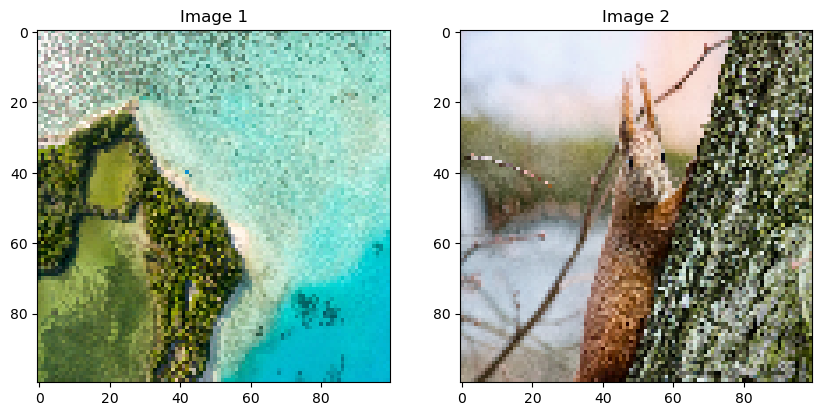

In [7]:
# Data: 2 images
path_img1 = "../image1.png"
path_img2 = "../image2.png"

img1 = cv2.imread(path_img1)
img2 = cv2.imread(path_img2)

# visualisation
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Image 1")
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Image 2")
plt.show()

In [8]:
print("Computing Similarity Matrix for Image 1...")
similarity_matrix1 = kernel(img1, gamma_s=0.001, gamma_c=0.001)
print("Computing Similarity Matrix for Image 2...")
similarity_matrix2 = kernel(img2, gamma_s=0.001, gamma_c=0.001)

Computing Similarity Matrix for Image 1...
Computing Similarity Matrix for Image 2...


## Normalized Cut

In [9]:
def Normalized_spectral_clustering(similarity_matrix, k, max_iter=100, tol=1e-6, init_method="random", output_dir="output", name="img", img_shape=None):
    """
    Perform spectral clustering and save intermediate results.
    Parameters:
    - similarity_matrix (numpy.ndarray): The similarity matrix (n_samples, n_samples).
    - k (int): Number of clusters.
    - max_iter (int): Maximum number of iterations for k-means.
    - tol (float): Tolerance for convergence in k-means.
    - init_method (str): Initialization method for k-means ("random" or "kmeans++").
    - output_dir (str): Directory to save images.
    - name (str): Name for the clustering experiment.
    - img_shape (tuple): Shape of the original image for visualizations.
    """
    n_samples = similarity_matrix.shape[0]

    # Compute Degree matrix
    D = np.diag(np.sum(similarity_matrix, axis=1))

    # Compute normalized Laplacian
    L = D - similarity_matrix
    D_inv_sqrt = np.diag(1 / np.sqrt(np.diag(D) + 1e-10))
    L_sym = np.dot(D_inv_sqrt, np.dot(L, D_inv_sqrt))

    # Compute eigenvectors of L_sym
    eigenvalues, eigenvectors = np.linalg.eigh(L_sym)
    U = eigenvectors[:, :k]  # Take the first k eigenvectors

    # Row normalize U
    T = U / np.linalg.norm(U, axis=1, keepdims=True)

    # Define a save callback function
    def save_callback(clusters, iteration):
        if img_shape is not None:
            save_iteration_visualization(name, img_shape, clusters, k, iteration, init_method, output_dir)

    # Apply k-means to rows of T
    clusters, _ = kmeans(T, k, max_iter=max_iter, tol=tol, init_method=init_method, save_callback=save_callback)

    # Visualize Eigen-space
    visualize_eigen_space(T, clusters, k, name + 'Normalized_Cut')

    return clusters

In [10]:
# Apply spectral clustering
name1 = "img1"
img_shape = img1.shape
name2 = "img2"

## Ratio Cut

In [11]:
def ratio_cut(similarity_matrix, k, max_iter=100, tol=1e-6, init_method="random", output_dir="output", name="img", img_shape=None):
    """
    Perform Ratio Cut clustering and save intermediate results.
    Parameters:
    - similarity_matrix (numpy.ndarray): The similarity matrix (n_samples, n_samples).
    - k (int): Number of clusters.
    - max_iter (int): Maximum number of iterations for k-means.
    - tol (float): Tolerance for convergence in k-means.
    - init_method (str): Initialization method for k-means ("random" or "kmeans++").
    - output_dir (str): Directory to save images.
    - name (str): Name for the clustering experiment.
    - img_shape (tuple): Shape of the original image for visualizations.
    Returns:
    - numpy.ndarray: Cluster assignments of shape (n_samples,).
    """
    n_samples = similarity_matrix.shape[0]
    print("Computing Degree matrix and Laplacian...")
    D = np.diag(np.sum(similarity_matrix, axis=1))
    L = D - similarity_matrix

    # Solve Generalized Eigenvalue Problem Lx = λDx
    print("Computing eigenvectors of L...")
    D_inv = np.linalg.inv(D + 1e-10 * np.eye(n_samples))  # Add small value for stability
    eigenvalues, eigenvectors = np.linalg.eig(np.dot(D_inv, L))

    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    U = eigenvectors[:, :k]

    U_normalized = U / np.linalg.norm(U, axis=1, keepdims=True)  # Normalize rows

    # Define a save callback function
    def save_callback(clusters, iteration):
        if img_shape is not None:
            save_iteration_visualization(name + '_ratio_cut', img_shape, clusters, k, iteration, init_method, output_dir)

    print("Applying k-means to rows of U_normalized...")
    clusters, _ = kmeans(U_normalized, k, max_iter=max_iter, tol=tol, init_method=init_method, save_callback=save_callback)

    # Visualize Eigen-space
    visualize_eigen_space(U_normalized, clusters, k, name + '_ratio_cut')

    return clusters

Clustering Image 1 with Normalized Spectral Clustering...


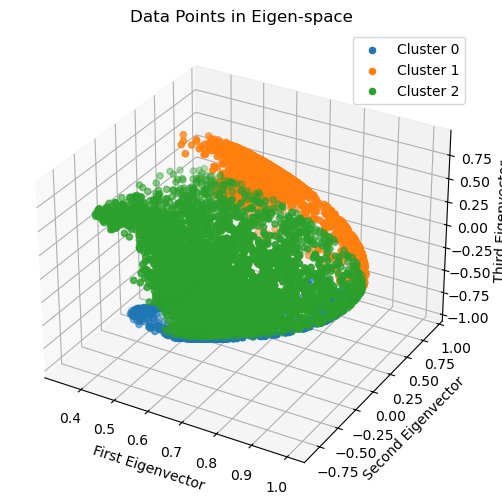

C:\Users\JALAL\AppData\Local\Temp\ipykernel_35432\656026354.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved at ./Spectral_Clustering_viz\img1\clustering_nb_cluster2_init_random.gif


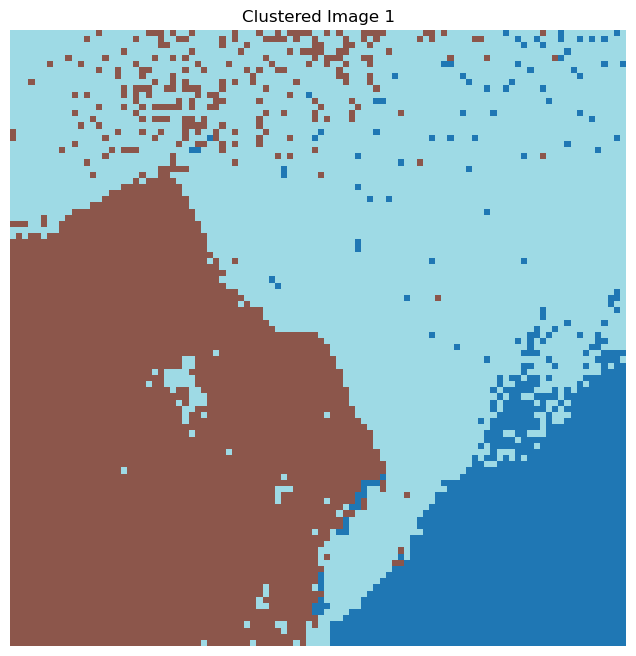

In [12]:
print("Clustering Image 1 with Normalized Spectral Clustering...")
clusters1 = Normalized_spectral_clustering(similarity_matrix1, k=3, init_method="random", output_dir=output_path, name=name1, img_shape=img_shape)
# Create GIF
create_gif(name1, output_path, k=3, initialize="random", max_iter=100)
visualize_clusters(img1, clusters1, title="Clustered Image 1")

In [13]:
print("Clustering Image 2 with Normalized Spectral Clustering...")
clusters2 = Normalized_spectral_clustering(similarity_matrix2, k=3, init_method="random", output_dir=output_path, name=name2, img_shape=img2.shape)
create_gif(name2, output_path, k=3, initialize="random", max_iter=100)
visualize_clusters(img2, clusters2, title="Clustered Image 2")

Clustering Image 2 with Normalized Spectral Clustering...


Clustering Image 1 with Ratio Cut...
Computing Degree matrix and Laplacian...
Computing eigenvectors of L...
Applying k-means to rows of U_normalized...


c:\Users\JALAL\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\JALAL\anaconda3\Lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


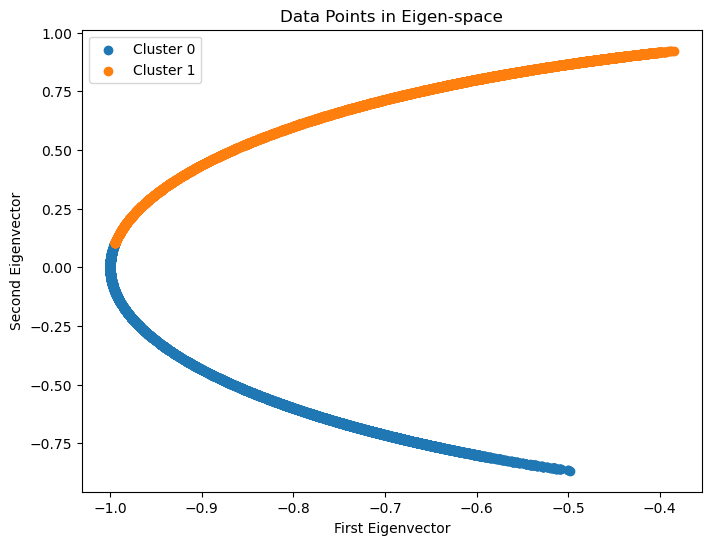

Creating GIF...


C:\Users\JALAL\AppData\Local\Temp\ipykernel_7120\656026354.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved at ./Spectral_Clustering_viz\img1_ratio_cut\clustering_nb_cluster2_init_random.gif


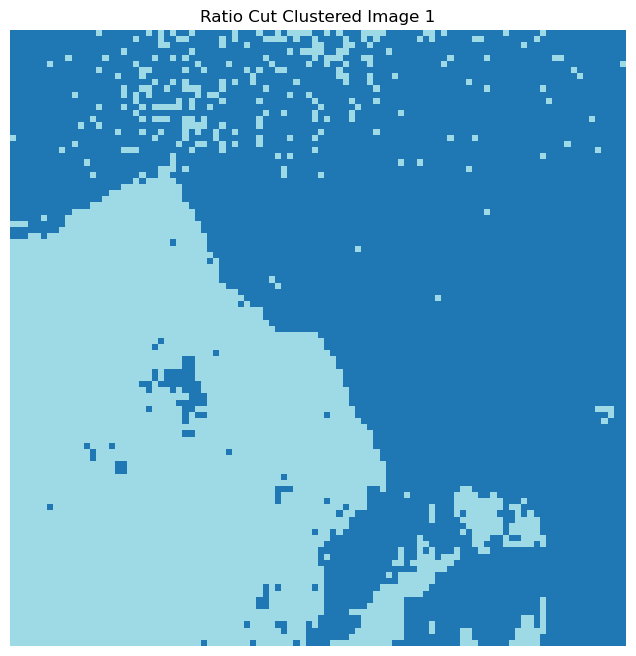

In [ ]:
print("Clustering Image 1 with Ratio Cut...")
clusters1_ratio = ratio_cut(similarity_matrix1, k=3, max_iter=100, tol=1e-6, init_method="random", output_dir=output_path, name=name1, img_shape=img_shape)
print('Creating GIF...')
create_gif(name1 + '_ratio_cut', output_path, k=3, initialize="random", max_iter=100)
visualize_clusters(img1, clusters1_ratio, title="Ratio Cut Clustered Image 1")

Clustering Image 2 with Ratio Cut...
Computing Degree matrix and Laplacian...
Computing eigenvectors of L...
Applying k-means to rows of U_normalized...


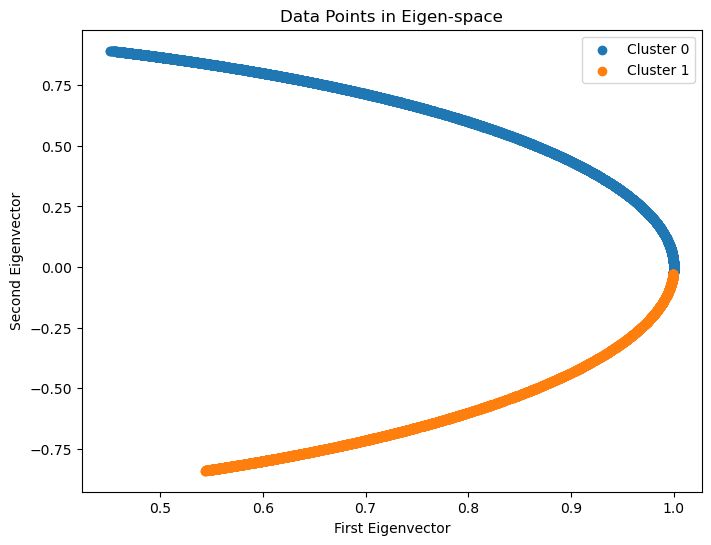

C:\Users\JALAL\AppData\Local\Temp\ipykernel_7120\656026354.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved at ./Spectral_Clustering_viz\img2_ratio_cut\clustering_nb_cluster2_init_random.gif


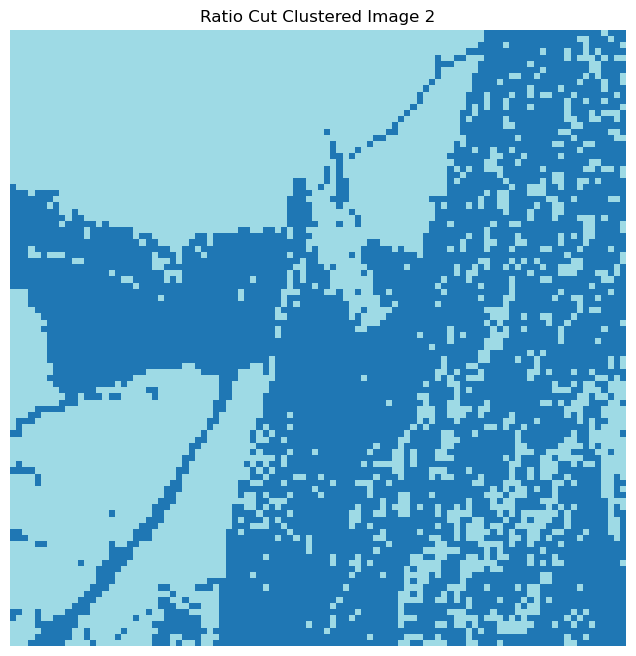

In [ ]:
print("Clustering Image 2 with Ratio Cut...")
clusters2_ratio = ratio_cut(similarity_matrix2, k=3, max_iter=100, tol=1e-6, init_method="random", output_dir=output_path, name=name2, img_shape=img2.shape)
create_gif(name2 + '_ratio_cut', output_path, k=3, initialize="random", max_iter=100)
visualize_clusters(img2, clusters2_ratio, title="Ratio Cut Clustered Image 2")